# BB Data Challenge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from datetime import date, time, datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregando arquivo csv usando Pandas 
arquivo = '/home/francis/Fila_cx/Dataset_publico.csv'
arquivo2 = '/home/francis/Fila_cx/X.csv'
dados = pd.read_csv(arquivo, delimiter = ";", header = 0)
dados2 = pd.read_csv(arquivo2, delimiter = ";", header = 0)

### Análise exploratória dos dados

In [3]:
dados.shape

(335612, 4)

In [4]:
dados.head()

,ID,ID_UOR,TS_INC_EPR,TS_INC_CHMD
0,0,0,2020-09-01 10:01:24,2020-09-01 10:02:13
1,1,0,2020-09-01 10:04:21,2020-09-01 10:22:01
2,2,0,2020-09-01 10:16:14,2020-09-01 10:25:06
3,3,0,2020-09-01 10:28:38,2020-09-01 10:28:40
4,4,0,2020-09-01 10:37:38,2020-09-01 10:37:41


In [5]:
dados.tail()

,ID,ID_UOR,TS_INC_EPR,TS_INC_CHMD
335607,376677,24,2021-07-30 13:05:56,2021-07-30 13:06:35
335608,376678,24,2021-07-30 13:12:09,2021-07-30 13:15:53
335609,376679,24,2021-07-30 13:17:08,2021-07-30 13:17:31
335610,376680,24,2021-07-30 13:27:15,2021-07-30 13:27:29
335611,376681,24,2021-07-30 13:30:20,2021-07-30 13:34:28


In [6]:
dados.isnull().sum()

ID               0
ID_UOR           0
TS_INC_EPR       0
TS_INC_CHMD    184
dtype: int64

In [7]:
dados.dtypes

ID              int64
ID_UOR          int64
TS_INC_EPR     object
TS_INC_CHMD    object
dtype: object

In [8]:
dados.groupby('ID_UOR').size()

ID_UOR
0     17712
1     24320
2     14169
3         4
4     17657
5     19304
6     15643
7       637
8     48775
9     15370
10    19787
11     8077
12     9392
13     6118
14     7723
15    15531
16     2157
17       39
18    11365
19    21035
20     5525
21    15042
22    21068
23    14598
24     4564
dtype: int64

In [9]:
df = dados

In [10]:
resp = dados2

In [11]:
len(df)

335612

### Tratando Dados Nulos

In [12]:
df.replace('', np.nan, inplace=True)

In [13]:
df.dropna(inplace=True)

In [14]:
len(df)

335428

In [15]:
df.isnull().sum()

ID             0
ID_UOR         0
TS_INC_EPR     0
TS_INC_CHMD    0
dtype: int64

In [16]:
df.dtypes

ID              int64
ID_UOR          int64
TS_INC_EPR     object
TS_INC_CHMD    object
dtype: object

### Tratando Campo Data

In [17]:
df["TS_INC_EPR"] = df.TS_INC_EPR.apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
df["TS_INC_CHMD"] = df.TS_INC_CHMD.apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))    
resp["DT"] = resp.DT.apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d'))    
resp["HH_INC"] = resp.HH_INC.apply(lambda x : pd.to_datetime(x, format='%H:%M:%S')) 
resp["HH_FIM"] = resp.HH_FIM.apply(lambda x : pd.to_datetime(x, format='%H:%M:%S')) 

In [18]:
#Split Datetime TS_INC_EPR
df["EPR_DT"] = df["TS_INC_EPR"].dt.strftime('%Y-%m-%d %H')

#Split Datetime TS_INC_CHMD
df["HORA_CHMD"] = df["TS_INC_CHMD"].dt.hour
df["CHMD_DT"] = df["TS_INC_CHMD"].dt.strftime('%Y-%m-%d')

#Criando coluna tempo de espera e espera superior a 15 minutos
df["TE"] = (df["TS_INC_CHMD"] - df["TS_INC_EPR"])
df["sup_15"] = [1 if timedelta.total_seconds(t) > 900 else 0 for t in df["TE"]]      

resp["hour"] = resp["HH_INC"].dt.hour

In [19]:
df.dtypes

ID                       int64
ID_UOR                   int64
TS_INC_EPR      datetime64[ns]
TS_INC_CHMD     datetime64[ns]
EPR_DT                  object
HORA_CHMD                int64
CHMD_DT                 object
TE             timedelta64[ns]
sup_15                   int64
dtype: object

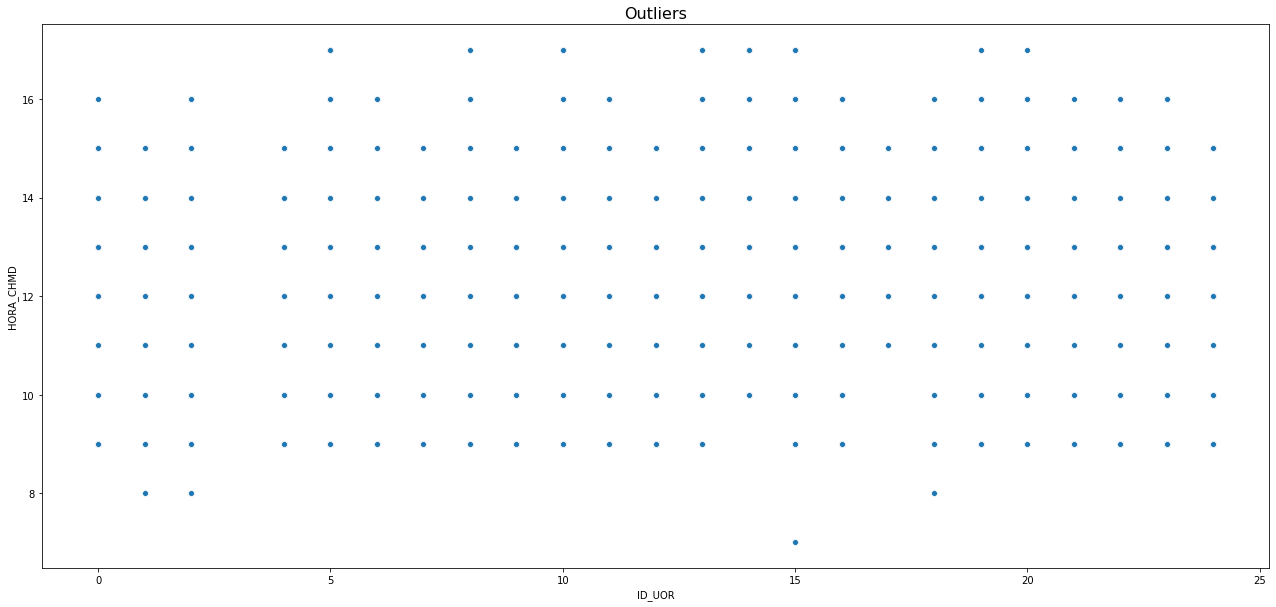

In [20]:
fig, ax = plt.subplots()
ax = sns.scatterplot (x = "ID_UOR", y = "HORA_CHMD", data = df)
ax.set_title('Outliers', fontsize = 16)
fig.set_size_inches((22,10))
plt.show()

In [21]:
df.tail()

,ID,ID_UOR,TS_INC_EPR,TS_INC_CHMD,EPR_DT,HORA_CHMD,CHMD_DT,TE,sup_15
335607,376677,24,2021-07-30 13:05:56,2021-07-30 13:06:35,2021-07-30 13,13,2021-07-30,0 days 00:00:39,0
335608,376678,24,2021-07-30 13:12:09,2021-07-30 13:15:53,2021-07-30 13,13,2021-07-30,0 days 00:03:44,0
335609,376679,24,2021-07-30 13:17:08,2021-07-30 13:17:31,2021-07-30 13,13,2021-07-30,0 days 00:00:23,0
335610,376680,24,2021-07-30 13:27:15,2021-07-30 13:27:29,2021-07-30 13,13,2021-07-30,0 days 00:00:14,0
335611,376681,24,2021-07-30 13:30:20,2021-07-30 13:34:28,2021-07-30 13,13,2021-07-30,0 days 00:04:08,0


In [22]:
resp.tail()

,ID,ID_UOR,DT,HH_INC,HH_FIM,hour
2635,2635,24,2021-08-31,1900-01-01 10:00:00,1900-01-01 10:59:59,10
2636,2636,24,2021-08-31,1900-01-01 11:00:00,1900-01-01 11:59:59,11
2637,2637,24,2021-08-31,1900-01-01 12:00:00,1900-01-01 12:59:59,12
2638,2638,24,2021-08-31,1900-01-01 13:00:00,1900-01-01 13:59:59,13
2639,2639,24,2021-08-31,1900-01-01 14:00:00,1900-01-01 14:59:59,14


In [23]:
df1 = df.loc[df.HORA_CHMD <= 14]

In [24]:
df2 = df1[['ID_UOR','CHMD_DT','HORA_CHMD','sup_15']]

In [25]:
df2.columns

Index(['ID_UOR', 'CHMD_DT', 'HORA_CHMD', 'sup_15'], dtype='object')

In [26]:
df2 = pd.DataFrame(df2.groupby(['ID_UOR','CHMD_DT','HORA_CHMD']).count())

In [27]:
len(df2)

21447

In [28]:
df3 = df1[['ID_UOR','CHMD_DT','HORA_CHMD','sup_15']]

In [29]:
df3 = pd.DataFrame(df3.groupby(['ID_UOR','CHMD_DT','HORA_CHMD']).sum())

In [30]:
len(df3)

21447

In [31]:
df4 = df3/df2

In [32]:
df4.tail()

sup_15
ID_UOR CHMD_DT    HORA_CHMD        
24     2021-07-29 13            0.0
       2021-07-30 10            0.0
                  11            0.0
                  12            0.0
                  13            0.0

In [33]:
df4 = df4.reset_index()

In [34]:
df4.head()

,ID_UOR,CHMD_DT,HORA_CHMD,sup_15
0,0,2020-09-01,10,0.1
1,0,2020-09-01,11,0.0
2,0,2020-09-02,10,0.0
3,0,2020-09-02,11,0.0
4,0,2020-09-02,12,0.0


In [35]:
df4["CHMD_DT"] = df4.CHMD_DT.apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d'))

In [36]:
df4.dtypes

ID_UOR                int64
CHMD_DT      datetime64[ns]
HORA_CHMD             int64
sup_15              float64
dtype: object

In [37]:
df4.head()

,ID_UOR,CHMD_DT,HORA_CHMD,sup_15
0,0,2020-09-01,10,0.1
1,0,2020-09-01,11,0.0
2,0,2020-09-02,10,0.0
3,0,2020-09-02,11,0.0
4,0,2020-09-02,12,0.0


In [38]:
df5 = df4

In [39]:
df5 = df5.loc[df5.CHMD_DT >= '2020-09-01']

In [40]:
df5.head()

,ID_UOR,CHMD_DT,HORA_CHMD,sup_15
0,0,2020-09-01,10,0.1
1,0,2020-09-01,11,0.0
2,0,2020-09-02,10,0.0
3,0,2020-09-02,11,0.0
4,0,2020-09-02,12,0.0


In [41]:
df5.sup_15 = df5.sup_15.apply(lambda x : x*100)

In [47]:
df5 = df5.set_index(['CHMD_DT'])
#df5 = df5.set_index(['ID_UOR','CHMD_DT','HORA_CHMD'])
#df.set_index(['year', 'month'])

In [51]:
df5 = df5.reset_index()

In [52]:
df5.head()

,CHMD_DT,ID_UOR,HORA_CHMD,sup_15
0,2020-09-01,0,10,10.0
1,2020-09-01,0,11,0.0
2,2020-09-02,0,10,0.0
3,2020-09-02,0,11,0.0
4,2020-09-02,0,12,0.0


### Previsão com XGBOOST

#### Dados de Treino e Teste

In [53]:
treino = df5.loc[df5.CHMD_DT < '2021-07-01']
teste = df5.loc[df5.CHMD_DT >= '2021-07-01']
treino.shape, teste.shape

((19271, 4), (2176, 4))

In [54]:
X_treino = treino[['ID_UOR','HORA_CHMD']].values
y_treino = treino[['sup_15']].values
X_teste = teste[['ID_UOR','HORA_CHMD']].values
y_teste = teste[['sup_15']].values

X_treino.shape, y_treino.shape, X_teste.shape, y_teste.shape

((19271, 2), (19271, 1), (2176, 2), (2176, 1))

### Treinando Modelo

In [55]:
from xgboost import XGBRegressor
modelo_xgb_um_dia = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgb_um_dia.fit(X_treino, y_treino)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
resp.head()

,ID,ID_UOR,DT,HH_INC,HH_FIM,hour
0,0,0,2021-08-02,1900-01-01 10:00:00,1900-01-01 10:59:59,10
1,1,0,2021-08-02,1900-01-01 11:00:00,1900-01-01 11:59:59,11
2,2,0,2021-08-02,1900-01-01 12:00:00,1900-01-01 12:59:59,12
3,3,0,2021-08-02,1900-01-01 13:00:00,1900-01-01 13:59:59,13
4,4,0,2021-08-02,1900-01-01 14:00:00,1900-01-01 14:59:59,14


In [57]:
resp1 = resp.drop(['ID','HH_INC', 'HH_FIM'], axis=1)

In [58]:
resp1 = resp1.set_index('DT')

In [59]:
resp1.head()

,ID_UOR,hour
DT,,
2021-08-02,0,10
2021-08-02,0,11
2021-08-02,0,12
2021-08-02,0,13
2021-08-02,0,14


In [60]:
resp2 = resp1[['ID_UOR', 'hour']].values

In [ ]:
#resp1 = resp1.reset_index()

In [61]:
predicao = modelo_xgb_um_dia.predict(X_teste)
predicao

array([2.6613457, 4.1868525, 4.4244328, ..., 5.806835 , 5.3505964,
       3.571526 ], dtype=float32)

In [ ]:
X_teste

### Fazendo Previsões

In [62]:
pred1 = modelo_xgb_um_dia.predict(resp2)
pred1

array([2.6613457, 4.1868525, 4.4244328, ..., 5.3505964, 3.571526 ,
       8.757624 ], dtype=float32)

In [63]:
len(resp2)

2640

In [64]:
pred1.size

2640

In [65]:
pred2 = pd.DataFrame(pred1)

In [66]:
pred2 = pred2.reset_index()

In [67]:
pred2.columns

Index(['index', 0], dtype='object')

In [68]:
pred2 = pred2.rename(columns = {'index':'ID',0:'PC_ACI_PZ'})

In [69]:
pred2.to_csv('respostaXGB.csv',sep = ';', float_format='%.2f', columns=['ID','PC_ACI_PZ'], index = False, encoding='utf-8',errors='strict')

In [72]:
pred2.min()

ID           0.000000
PC_ACI_PZ   -0.416557
dtype: float64